In [4]:
# !pip install cellrank
# !pip install scanpy
# !pip install scipy
# !pip install anndata


In [7]:
%%bash

source downloadData.sh

# !mkdir -p ./data

# scRNA-seq TF-driven forward programmed hiPSCs to multiple fates
download_dataset "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE154759&format=file&file=GSE154759%5Fadata%2Eh5ad%2Egz" "./data" "GSE154759_adata.h5ad.gz"
gunzip_download ./data/GSE154759_adata.h5ad.gz

# raw dataset
download_dataset "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE154759&format=file&file=GSE154759%5FRAW%5Fmatrix%2Etsv%2Egz" "./data" "GSE154759_RAW_matrix.tsv.gz"
gunzip_download ./data/GSE154759_RAW_matrix.tsv.gz


The file ./data/GSE154759_adata.h5ad.gz already exists. Skipping download.
File ./data/GSE154759_adata.h5ad already exists. Skipping.
The file ./data/GSE154759_RAW_matrix.tsv.gz already exists. Skipping download.
File ./data/GSE154759_RAW_matrix.tsv already exists. Skipping.


In [8]:
import cellrank as  cr
import scanpy as sc
from scipy import sparse
import pandas as pd
import numpy as np
from anndata import AnnData

             n_genes  percent_mito  n_counts            leiden
index                                                         
CD144p01F05     7708      0.067751  285236.0  Endothelial-like
CD144p01F07     7451      0.083326  332922.0  Endothelial-like
CD144p01F08     7912      0.065537  305981.0  Endothelial-like
CD144p01F09     6491      0.083964  326961.0  Endothelial-like
CD144p01F10     7332      0.078745  303713.0  Endothelial-like
          n_cells  highly_variable     means  dispersions  dispersions_norm
index                                                                      
ISG15          63             True  3.274641     3.902523          1.111848
AL390719       17             True  1.681478     3.617845          1.236657
MXRA8          15             True  1.623792     3.815594          1.659077
ANKRD65        21             True  2.719232     4.606602          2.881019
GNB1           86             True  3.639803     3.632690          0.326546
94
1
Index(['ISG15', 'AL390

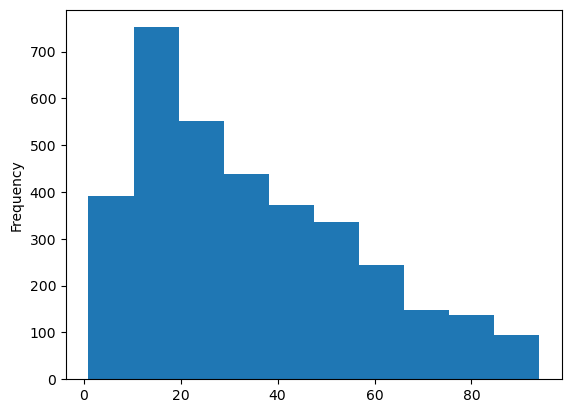

In [9]:
adata = sc.read_h5ad("data/GSE154759_adata.h5ad")

print(adata.obs.head())
print(adata.var.head())


print(adata.var["n_cells"].max())
print(adata.var["n_cells"].min())

# plot this cell distribution

adata.var["n_cells"].plot.hist()
# print the index
# print(adata.var.index)
COUNT_VAR = 5

adata = adata[:, adata.var["n_cells"] > COUNT_VAR]

print(adata.var["highly_variable"].value_counts()) # they are all true
# approx 3.3k have over 5 cells...



In [10]:
# however I don't really trust the highly variable genes
# I will look into the original datast to see if I can understand
# GSE154759_RAW_matrix.tsv
df = pd.read_csv("data/GSE154759_RAW_matrix.tsv", sep="\t")
adata2 = AnnData(X=df.values.T, obs=pd.DataFrame(index=df.columns), var=pd.DataFrame(index=df.index))

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Here I am trying to redo some data analysis on the raw data. Where we have about 83 features (which are like genes)

First I try and get the data into a sparse matrix format. Then I try and do some basic data analysis on the data.

Then we want to get a diffusian map (like a difflouvain) on the data. This is a way to reduce the dimensionality of the data and to get a better understanding of the data. Which I will have to do manually because anndata is weird AF

AnnData object with n_obs × n_vars = 57672 × 95
    obs: 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
(57672, 95)


/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


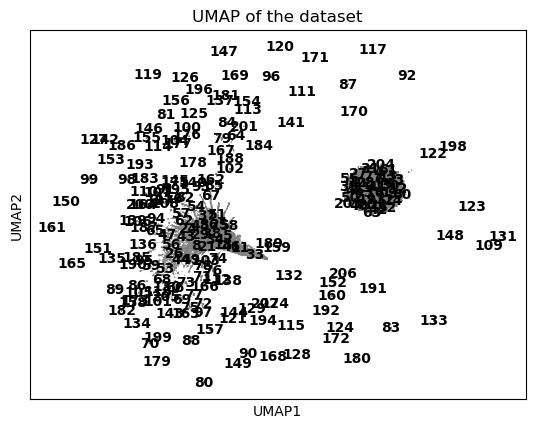

In [39]:
# print(adata2.var.head())
# print(adata2.obs.head())
print(adata2)
print(adata2.X.shape)

# perform pca on X

# remove the first row. Not sure if this is correct, but I was having issues with the headers... (maybe I can just add them as headers?) 
firstRow = adata2.X[0, :]
adata2 = adata2[1:, :]
# adata2.X = sparse.csr_matrix(adata2.X) # why cannot make sparse... 
sc.pp.pca(adata2)


# how to change the sensitivity of the pca?

import umap
import scanpy as sc

# Assuming 'adata2' is your AnnData object with PCA already computed
reducer = umap.UMAP()
embedding = reducer.fit_transform(adata2.obsm['X_pca'])
adata2.obsm['X_umap'] = embedding

# Now, for community detection using Louvain (or Leiden)
sc.pp.neighbors(adata2, use_rep='X_umap')  # Compute the neighborhood graph
sc.tl.louvain(adata2)  # or sc.tl.leiden(adata2) for the Leiden algorithm

# Plotting the UMAP with Louvain clusters
sc.pl.umap(adata2, color='louvain', title="UMAP of the dataset", legend_loc="on data")

The UMAP doesn't make much sense to me as we have a ton of different clusters. 

In [15]:

print(adata2.obs["louvain"].value_counts())
# print(adata2.obs["louvain"].head())


louvain
0      1904
1      1560
2      1502
3      1416
4      1404
       ... 
201      16
202      15
203      15
204      15
205      15
Name: count, Length: 206, dtype: int64


now I want to group the data into the TFs and use this to see the entropy between the different TFs to see if they are actually interestingly expressed.

In [38]:
# I lost where is the different TFs.... in this dataset. 
print(adata2)

# these are my different clusters
print(adata2.obs['louvain'].unique())

# I am pretty sure this one now doesn't have the TFs??? 


AnnData object with n_obs × n_vars = 57672 × 95
    obs: 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
['31', '8', '19', '1', '2', ..., '197', '140', '151', '205', '198']
Length: 206
Categories (206, object): ['0', '1', '2', '3', ..., '202', '203', '204', '205']
AxisArrays with keys: X_pca, X_umap
